In [18]:
from jedi import jedi
from jedi.utils import plot, seedutil

import random
import types
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from __future__ import division
from scipy.integrate import odeint, ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice

from ipywidgets import interact, fixed
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [7]:
# Setting Seeds
seeds = uniform(0,10000,1).astype(int)

# Test Signals

## 1) Sin Wave

In [9]:
# sine-wave target
target = lambda t0: cos(2 * pi * t0 / 5)

In [10]:
# simulation parameters for FORCE
dt = .1      # time step
tmax = 100   # simulation length
tstop = 500  # learning stop time
g = 1.5    # gain factor?
N = 300     # size of stochastic pool
lr = 1   # learning rate

In [11]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [12]:
errors = []

for seedling in seeds:
    J, Wz, _, x0, u, w = seedutil.set_simulation_parameters(seedling, N, 1, (.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return -x + g * dot(J, tanh_x) + Wz*z 
    
    x,t,z,_,wu,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

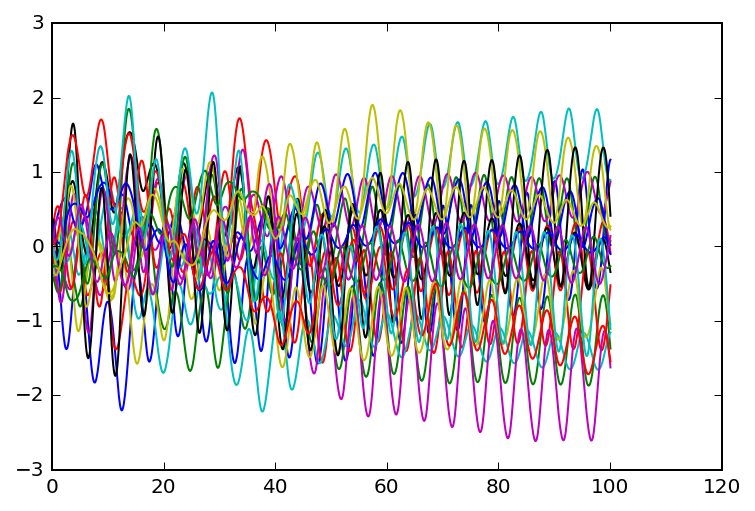

In [13]:
# Visualizing activities of first 20 neurons
for i in range(20):
    plt.plot(t[-1000:], x[-1000:, i]);

In [23]:
pca = PCA(n_components=3)
pca.fit(x)

PCA(copy=True, n_components=3, whiten=False)

In [24]:
pca_x = pca.transform(x).T

In [25]:
def visualize_3dim_state(time, pca_x):
    ti = np.argmax(tv >= time)
    ax = plt.figure(figsize=(10,10)).add_subplot(111, projection='3d')
    ax.scatter(pca_x[0][ti], pca_x[1][ti], pca_x[2][ti], c='red');
    plt.plot(pca_x[0][:ti], pca_x[1][:ti], pca_x[2][:ti]);
    
def visualize_2dim_state(time, pca_x):
    ti = np.argmax(tv >= time)
    plt.figure(figsize=(6,6))
    plt.plot(pca_x[0][:ti], pca_x[1][:ti])
    plt.plot(pca_x[0][ti], pca_x[1][ti], 'ro')

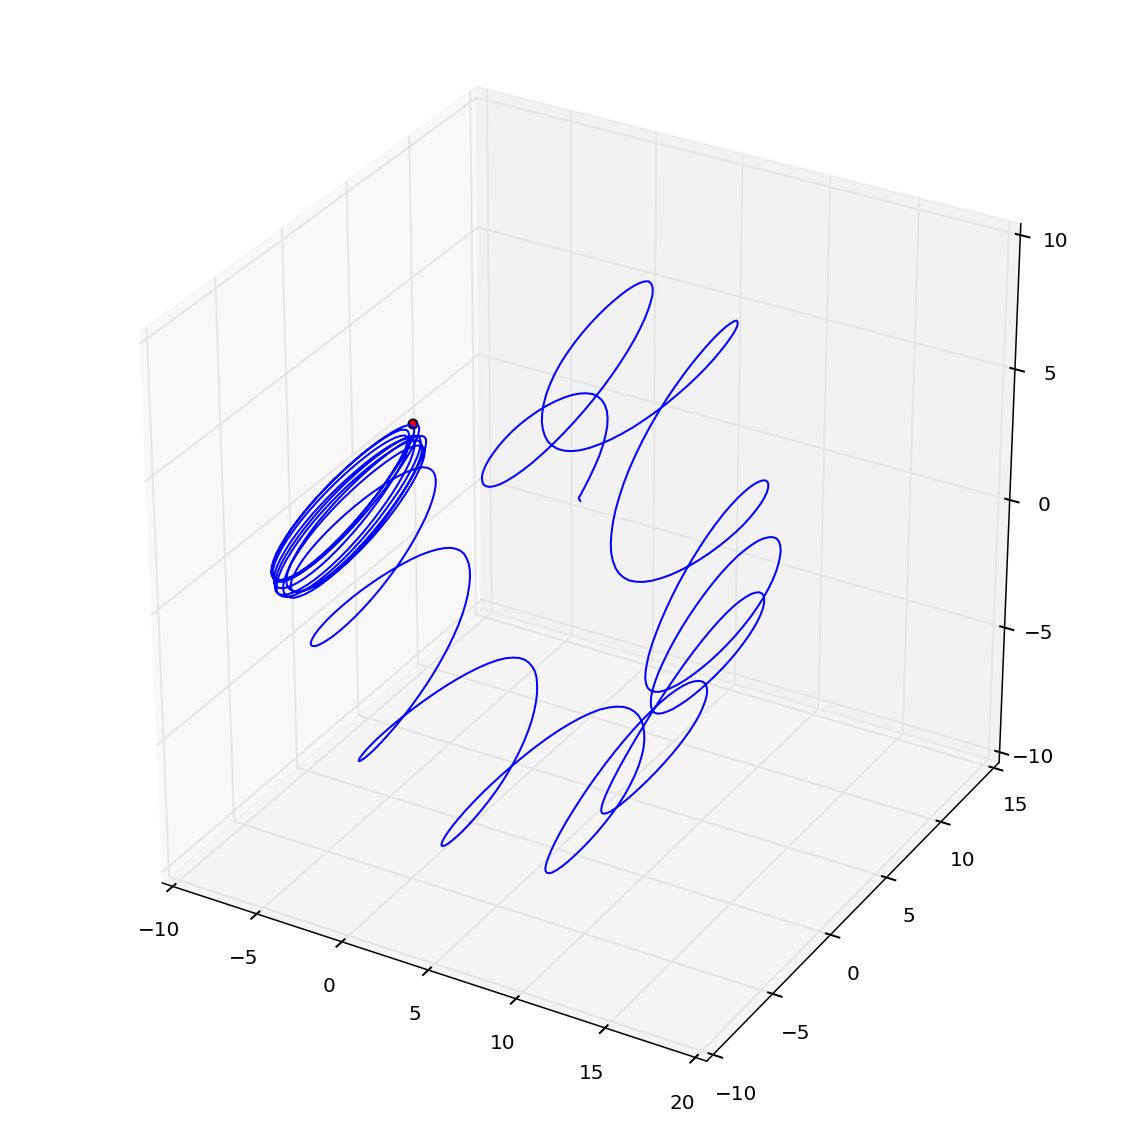

In [26]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

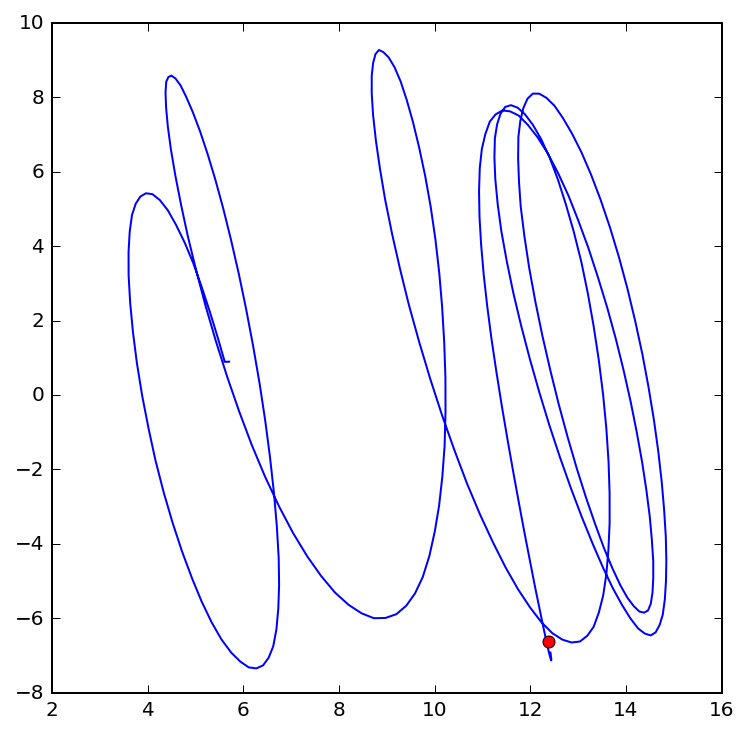

In [19]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x));

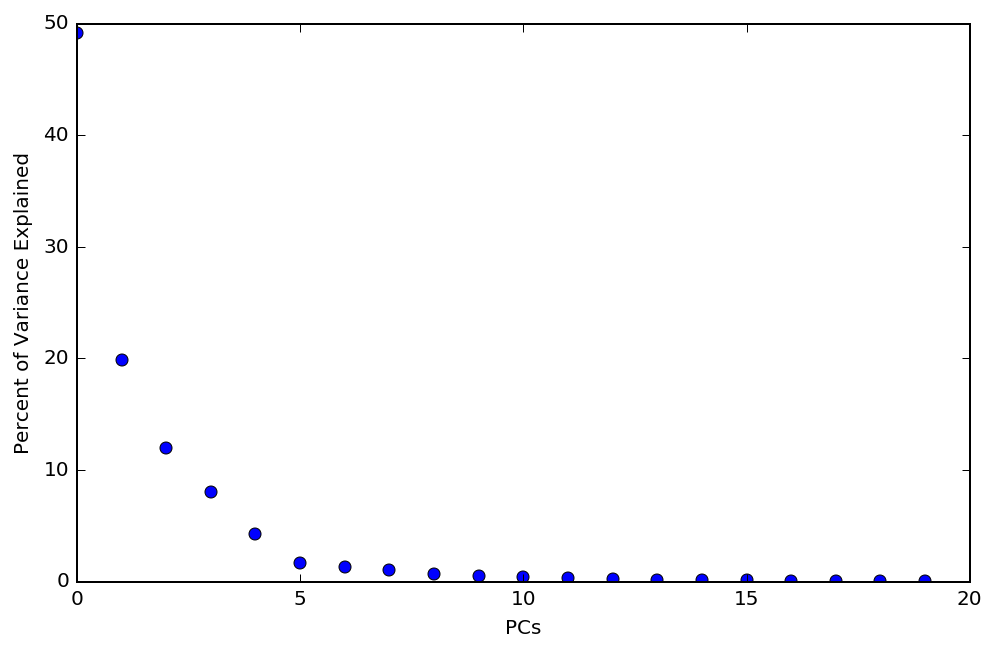

In [21]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");

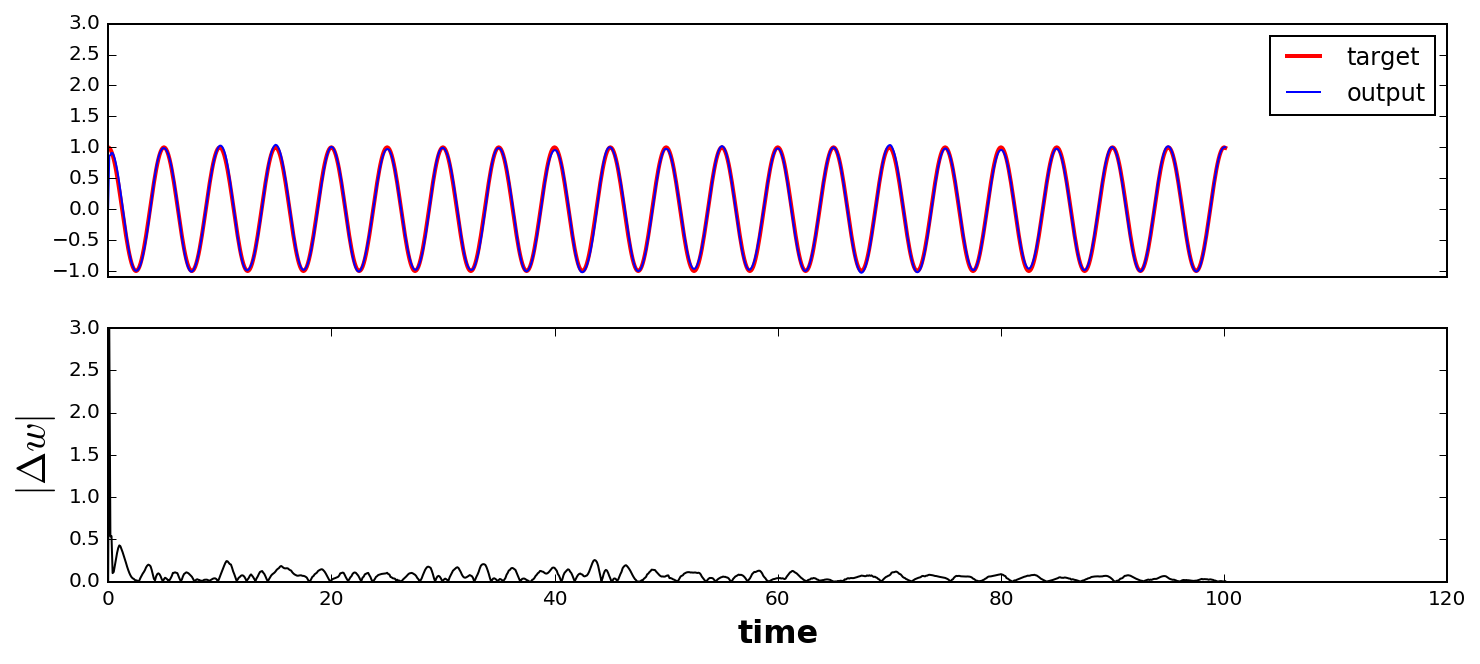

In [20]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t, tstop, title= "FORCE (Sin Wave)", burn_in=5)
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

In [ ]:
# simulation parameters for SFORCE
dt = .1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5     # gain factor?
N = 1000     # size of stochastic pool
lr = 1     
rho = 100

In [ ]:
derrors = []

for seed in seeds:
    J, Wz, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, (.1,1,1))
    
    def model(t0, x, tanh_x, inp, z): 
        return -x + g * dot(J, tanh_x) + Wz*z
    
    x,t,z,_,wu,_ = jedi.sforce(rho, target, model, lr, dt, tmax, tstop, x0, w)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

In [ ]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstop, title="SFORCE (Sin Wave)", burn_in=5)
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

In [ ]:
for i in range(20):
    plt.plot(t[-1000:], x[-1000:, i]);

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)

In [ ]:
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_2dim_state, time=(tmin, tmax, .1));

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Sin Wave)");

In [ ]:
plt.figure(figsize=(12,3))
plot.cross_signal_error(errors, derrors, t, tstop, 
                        title="FORCE vs SFORCE (Sin Wave))", burn_in=100)

## 2) 1D Flip-Flop

In [ ]:
def gen_inp_targets():
    # Setting targets for flip-flop task
    targets = ones(int(tmax/dt))
    targets[range(1000,2310)] = -1
    targets[range(3000,3510)] = -1
    targets[range(4500,5010)] = -1
    targets[range(6500,7510)] = -1
    targets[9700:] = -1

    # Setting inputs for flip-flop task
    inputs = zeros(int(tmax/dt))
    inputs[range(1000,1110)] = -1
    inputs[range(1650,1760)] = -1
    inputs[range(2300,2410)] = 1
    inputs[range(3000,3110)] = -1
    inputs[range(3500,3610)] = 1
    inputs[range(4500,4610)] = -1
    inputs[range(5000,5110)] = 1
    inputs[range(6500,6610)] = -1
    inputs[range(7500,7610)] = 1
    inputs[range(8200,8310)] = 1
    inputs[range(9700,9810)] = -1

    inputs = inputs.tolist()
    targets = targets.tolist()
    
    return inputs, targets

In [ ]:
# Plotting inputs and targets
inputs, targets = gen_inp_targets()
plt.figure(figsize=(12, 3))
plt.plot(range(int(tmax/dt)), targets, label="Target");
plt.plot(range(int(tmax/dt)), inputs, label="Input");
plt.ylim(-2,2);
plt.legend();

In [ ]:
dt = .1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 1000     # size of stochastic pool
I = 1    # input size
lr = 1     # learning rate

In [ ]:
errors = []
wus = []
zs = []

for seed in seeds:
    J, Wz, Wi, x0, u, w = seedutil.set_simulation_parameters(seed, N, I, p=(.1,1,1))
    
    def model(t0, x, tanh_x, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, inputs)
    
    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

In [ ]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t[1:], tstop, title= "FORCE (Flip-Flop)", burn_in=5)

In [ ]:
ind = 0

In [ ]:
plt.figure(figsize=(12,5))
if ind < len(seeds):
    print("Seed: %d" % ind)
    plot.signal_error(errors[ind], t[1:], tstop, 
                  title= "FORCE (Flip-Flop)", burn_in=5, mean=False)
    plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)
    ind+=1

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(t, np.array(z)-5, lw=3, label="output")
plt.legend()
for i in range(20):
    plt.plot(t[:], x[:, i]);

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[-5000]
tv = t[-5000:]

interact(visualize_2dim_state, time=(tmin, tmax, .1));

In [5]:
dt = .1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 1000     # size of stochastic pool
I = 1    # input size
lr = 1    # learning rate
rho = 100

In [ ]:
derrors = []
wus = []
zs = []

for seed in seeds:
    J, Wz, Wi, x0, u, w = seedutil.set_simulation_parameters(seed, N, I, p=(.1,1,1))
    
    def model(t0, x, tanh_x, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z
    
    
    x,t,z,_,wu,_ = jedi.sforce(rho, targets, model, lr, dt, tmax, tstop, x0, w, inputs)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

In [ ]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t[1:], tstop, title="SFORCE (Flip-Flop)", burn_in=5)

In [ ]:
# Setting seed index
ind = 0

In [ ]:
plt.figure(figsize=(12,5))
# Comparing performance across seeds
if ind < len(seeds):
    print("Seed: %d" % ind)
    plot.signal_error(derrors[ind], t[1:], tstop, title= "SFORCE", burn_in=5, mean=False)
    plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)
    ind+=1

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(t, np.array(z)-5, lw=3, label="output")
plt.legend()
for i in range(20):
    plt.plot(t[:], x[:, i]);

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("DFORCE (Flip Flop)");

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_2dim_state, time=(tmin, tmax, .1));

In [ ]:
# cross mean signal error
plt.figure(figsize=(12,5))
plot.cross_signal_error(errors, derrors, t[1:], tstop, 
                        title="FORCE vs SFORCE (Flip-Flop)", burn_in=5)

In [ ]:
# Setting seed index
ind = 0

In [ ]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.cross_signal_error(errors[ind], derrors[ind], t[1:], tstop, 
                        title="FORCE vs SFORCE, (Flip-Flop)", 
                        burn_in=5, mean=False)
ind+=1

## 3) Lorentz Attractor

In [40]:
# Parameters specified by Abbott 2009.
def lorentz((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [41]:
T = 15000 # period
x0 = [1, 1, 1]  # starting vector
t_= np.linspace(0, 40, T)  # one thousand time steps
lorenz = odeint(lorentz, x0, t_)/10
targets = lorenz[5000:,1]

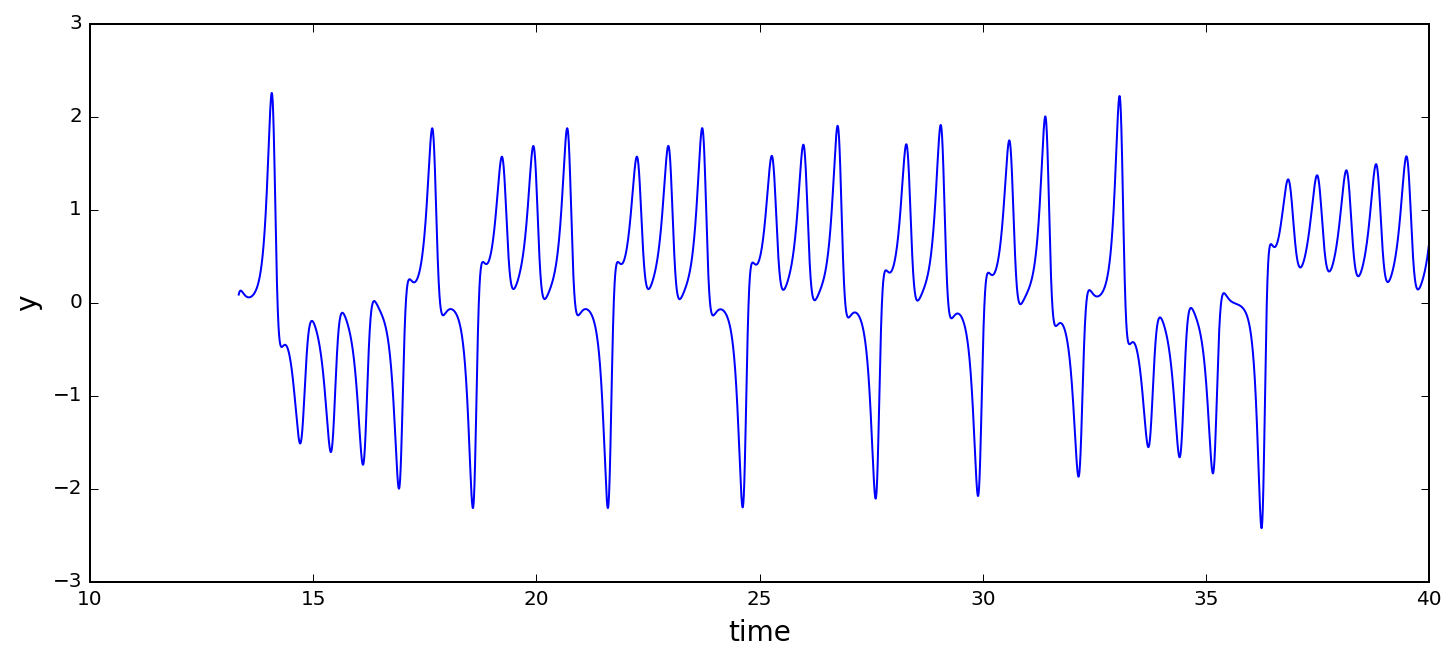

In [42]:
# Visualizing Lorentz attractor
plt.figure(figsize=(12,5))
plt.plot(t_[5000:], targets);
plt.xlabel('time', fontsize=14);
plt.ylabel('y', fontsize=14);

In [43]:
dt = .1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 1000      # size of stochastic pool
lr = 1.0     # learning rate

In [44]:
errors = []
wus = []
zs = []

for seed in seeds:
    print("Seed: %d" % seed)
    
    J, Wi, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, p=(.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(z, Wi)
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)

errors = np.array(errors)

Seed: 6132


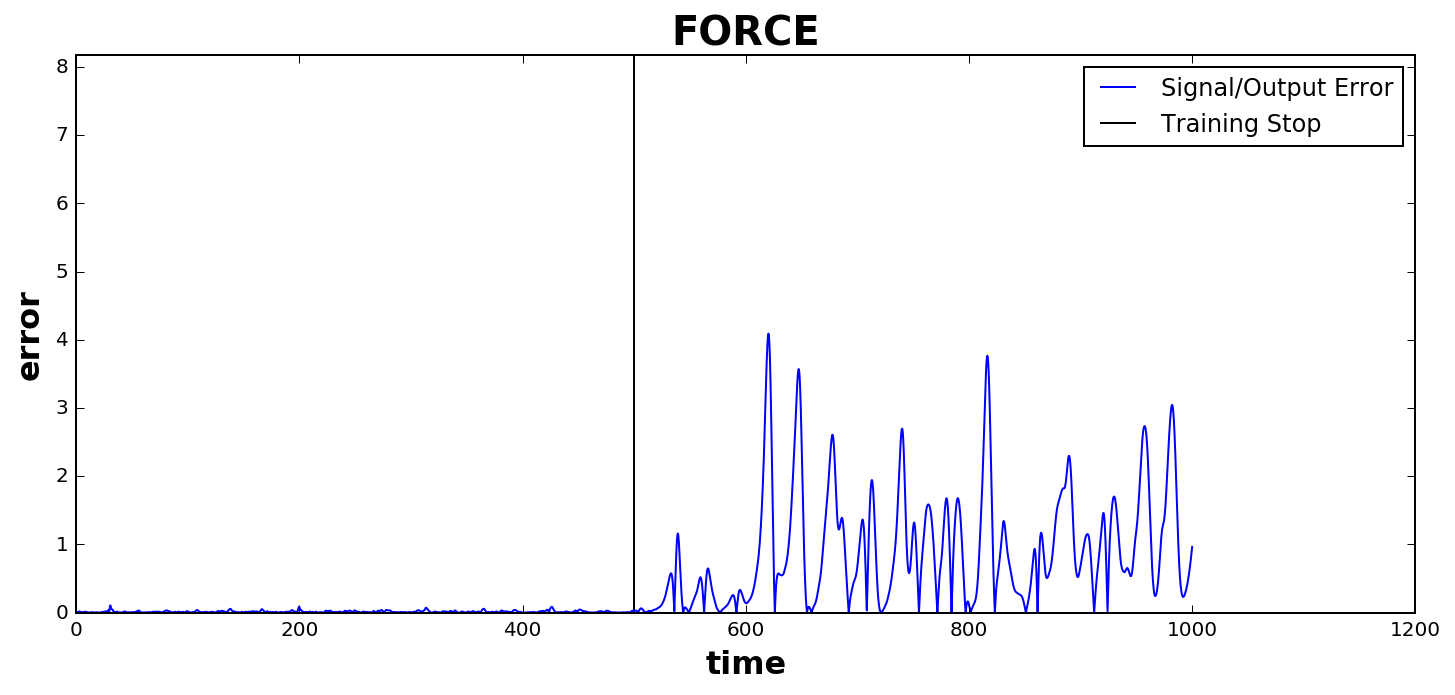

In [45]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t[1:], tstop, title= "FORCE", burn_in=5)

In [46]:
ind = 0

Seed: 0


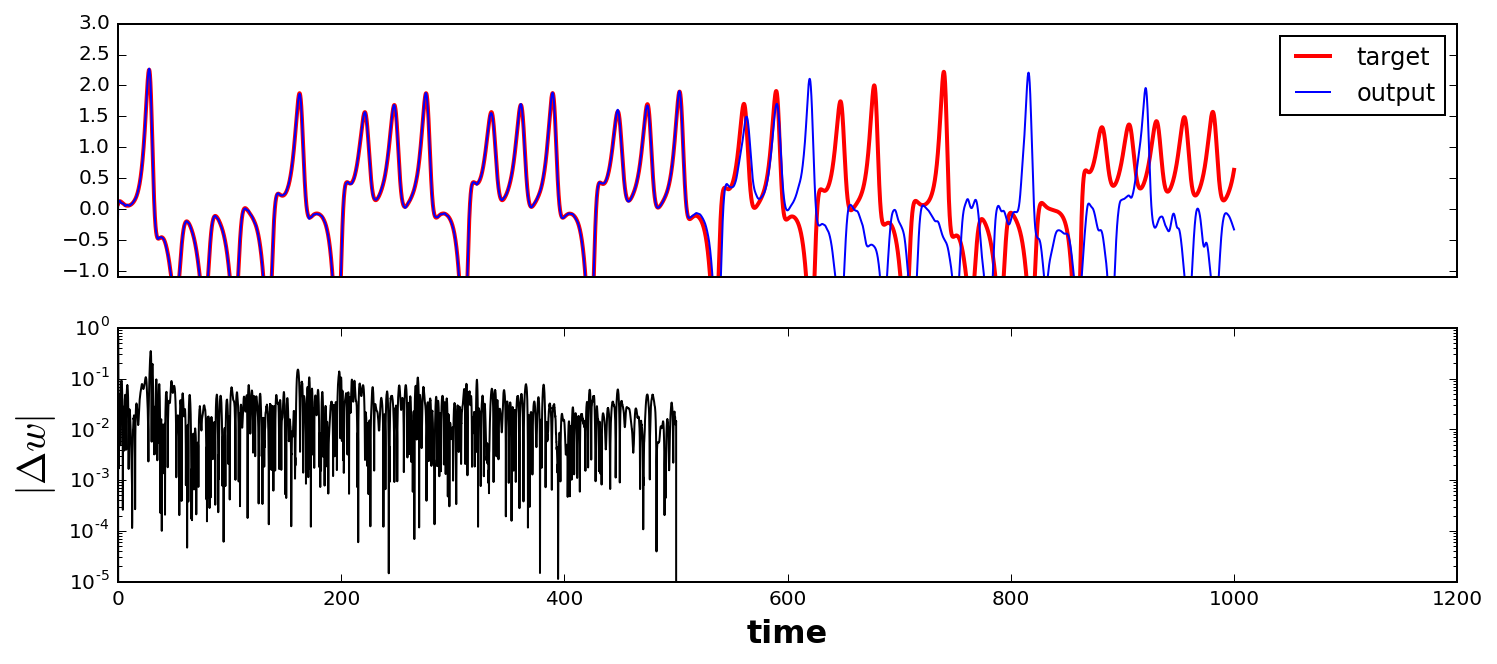

In [47]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.signal_error(errors[ind], t[1:], tstop, 
                  title= "FORCE", burn_in=5, mean=False)
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

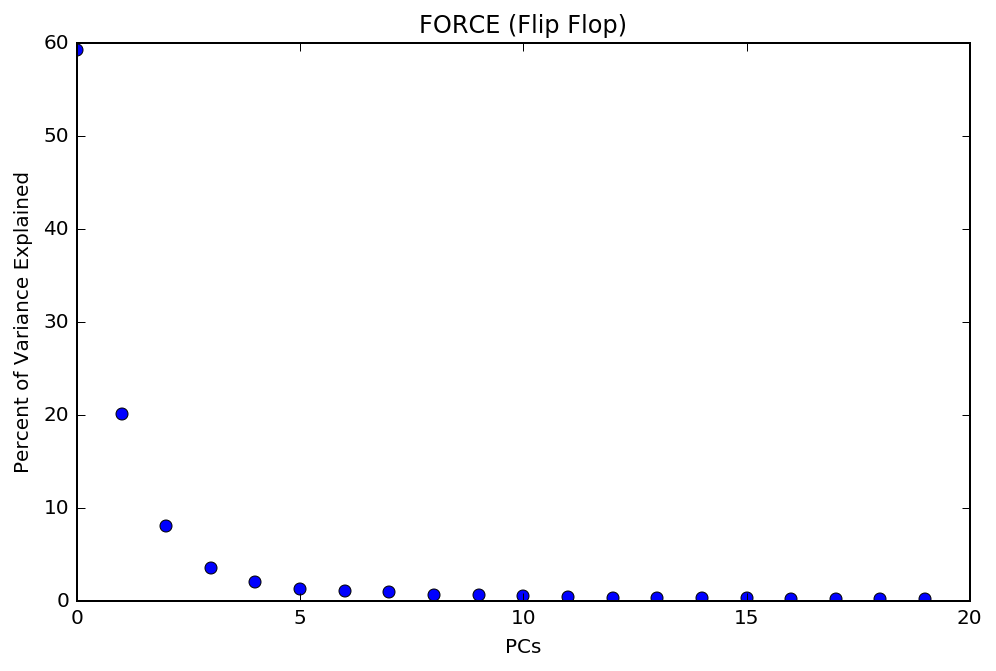

In [48]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [49]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_3dim_state, time=(tmin, tmax, .1));

In [24]:
dt = .1       # time step
tmax = 1000  # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 1000      # size of stochastic pool
lr = 1      # learning rate
rho = 100

In [26]:
derrors = []
wus = []
zs = []

for seed in seeds:
    print("Seed: %d" % seed)
    J, Wi, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, p=(.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(z, Wi)
    
    x,t,z,_,wu,_ = jedi.sforce(rho, targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Seed: 578


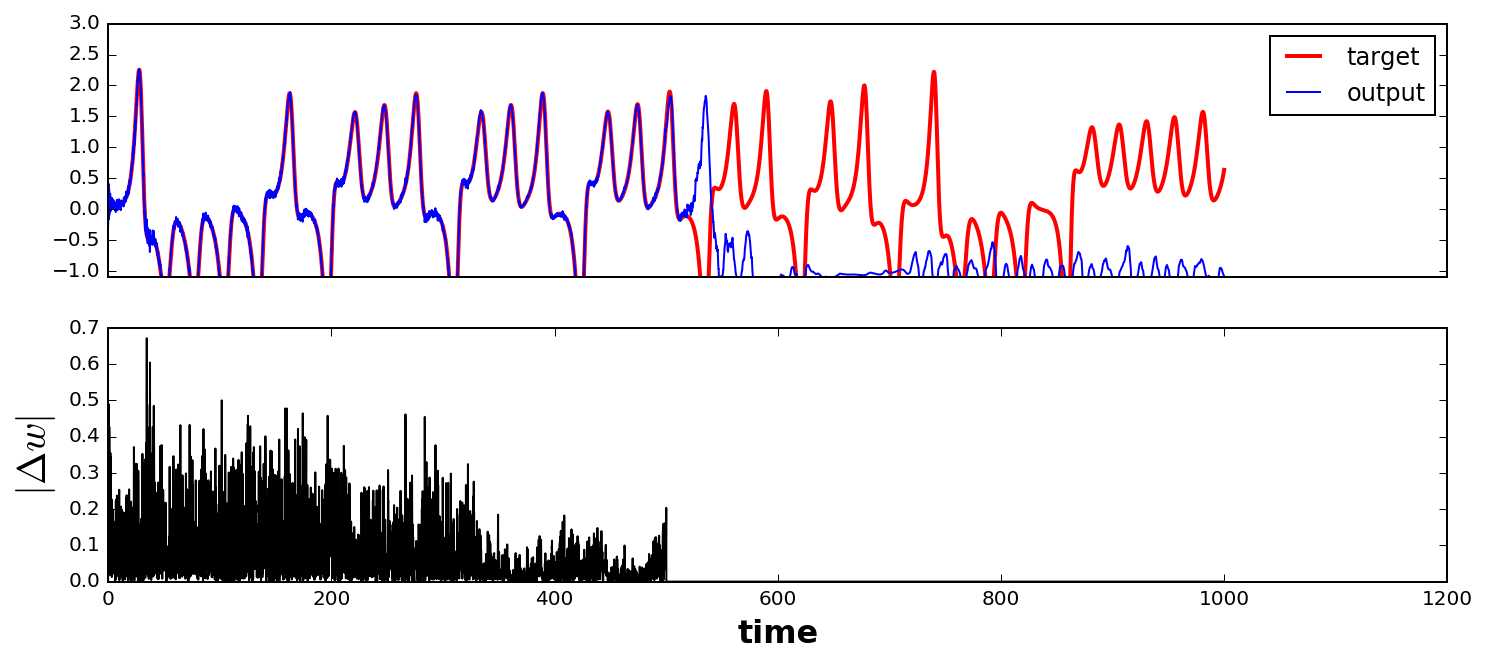

In [37]:
plt.figure(figsize=(12,5))
ind = 0 
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)

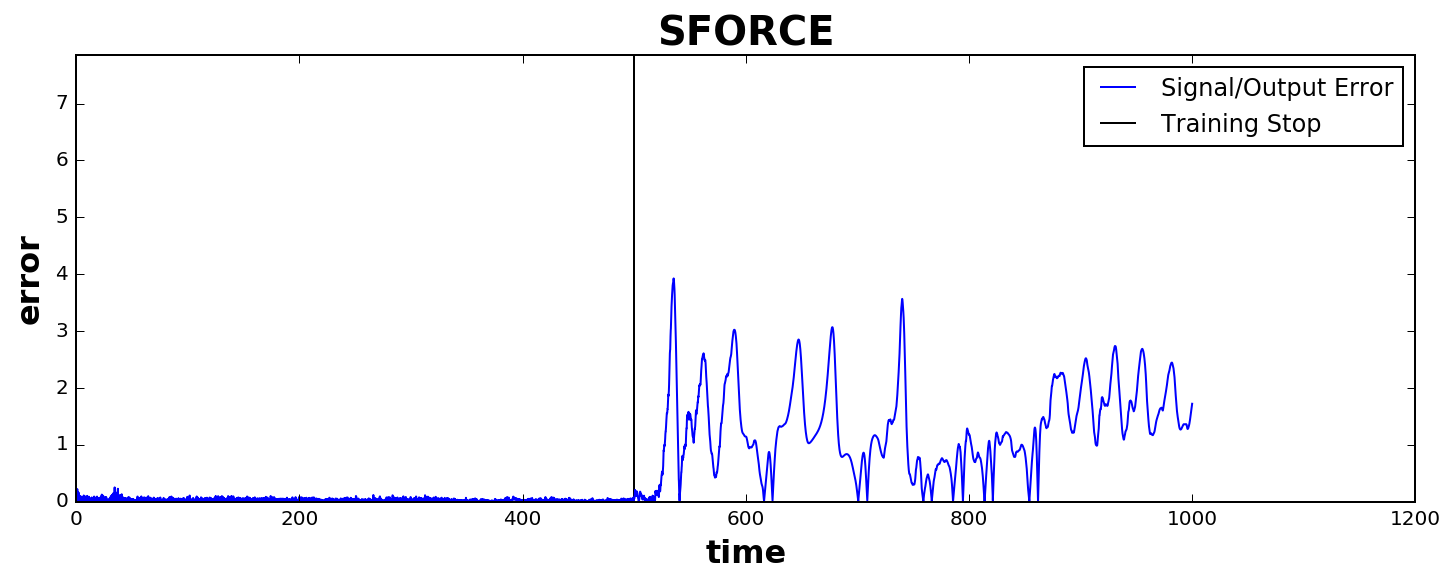

In [35]:
plt.figure(figsize=(12,4))
plot.signal_error(derrors, t[1:], tstop, title= "SFORCE", burn_in=5)

Seed: 0


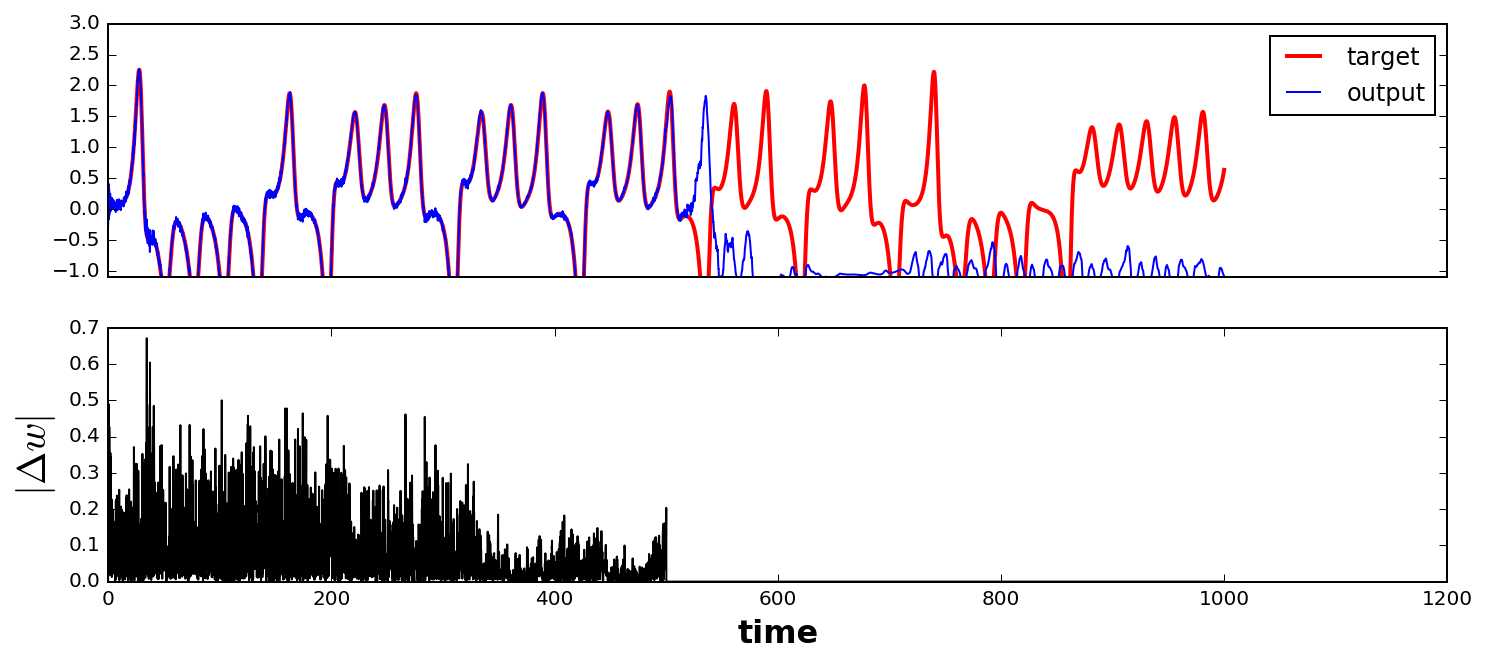

In [38]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.signal_error(derrors[ind], t[1:], tstop, 
                  title= "SFORCE", burn_in=5, mean=False)
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)
ind+=1

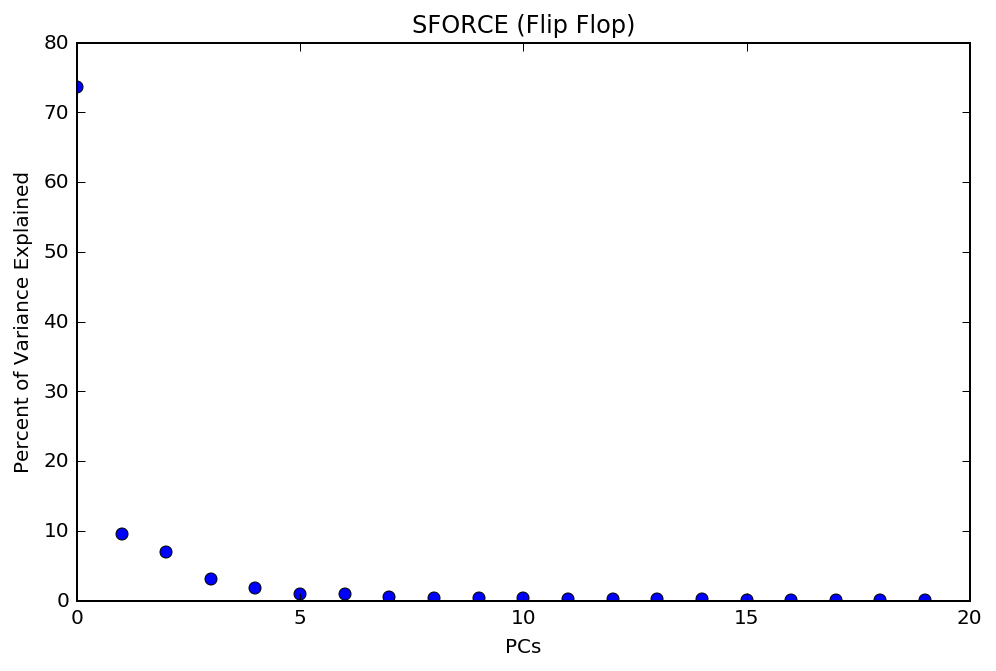

In [30]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Flip Flop)");

In [31]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

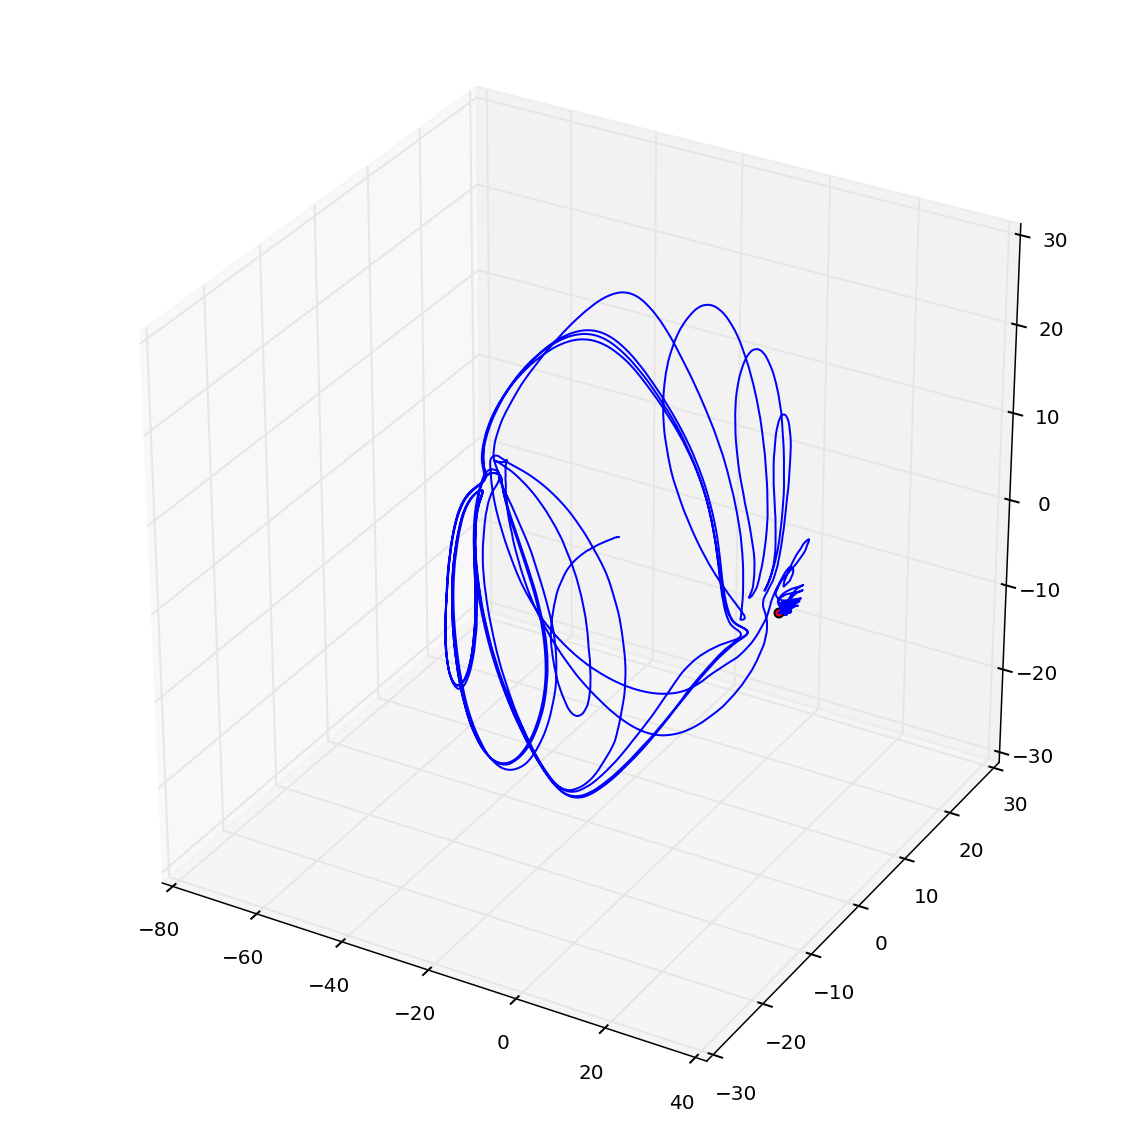

In [32]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_3dim_state, time=(tmin, tmax, .1));

In [ ]:
# cross mean signal error
plot.cross_signal_error(errors, derrors, t[1:], tstop, 
                        title="FORCE vs SFORCE (Lorentz)", burn_in=5)